# Imports

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Loading and cleaning data

In [12]:
# Load data
DATA_PATH = "/Users/teymour/Desktop/cmor438/data/diamond-prices.csv"
df = pd.read_csv(DATA_PATH)

# Clean data (drop NA)
df = df.dropna()

# Data exploration

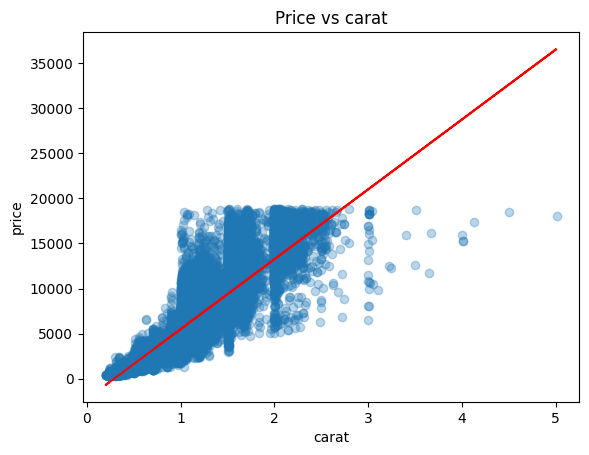

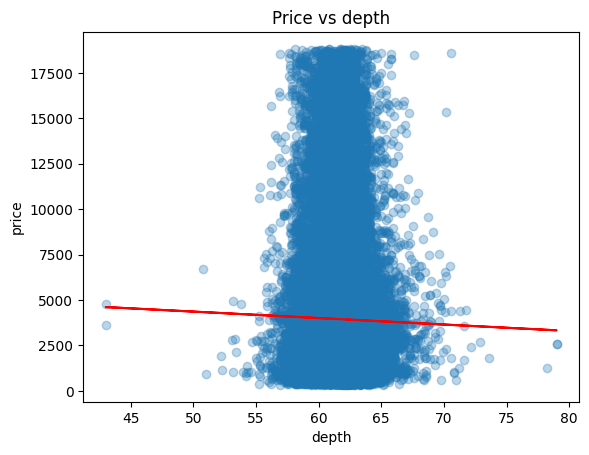

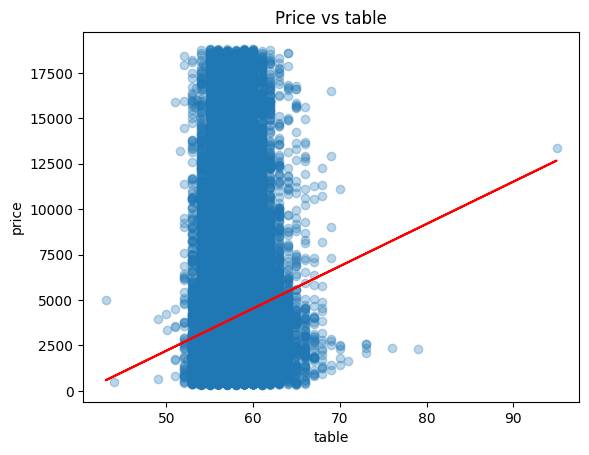

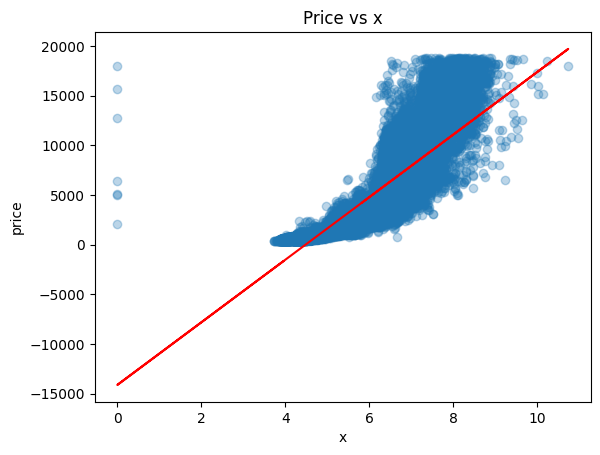

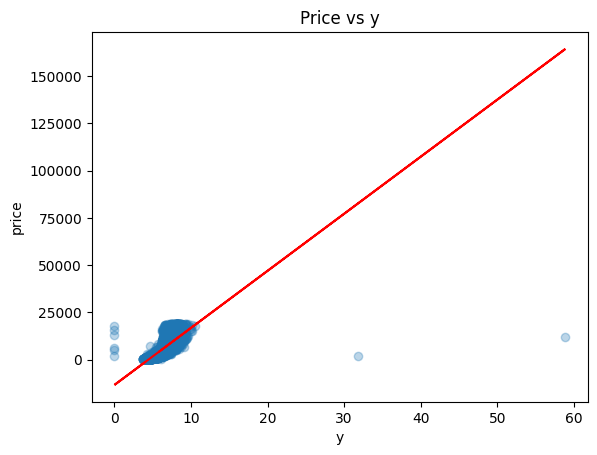

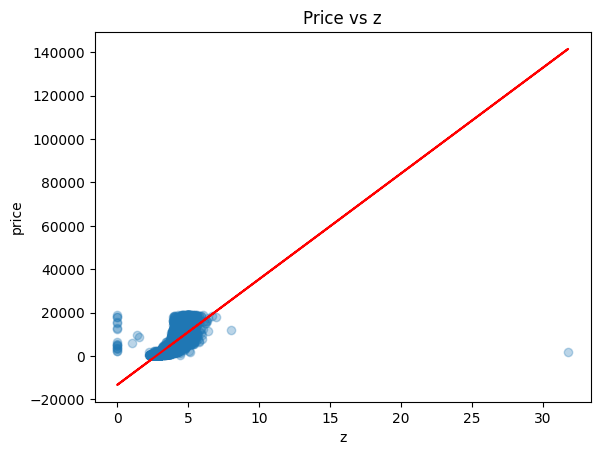

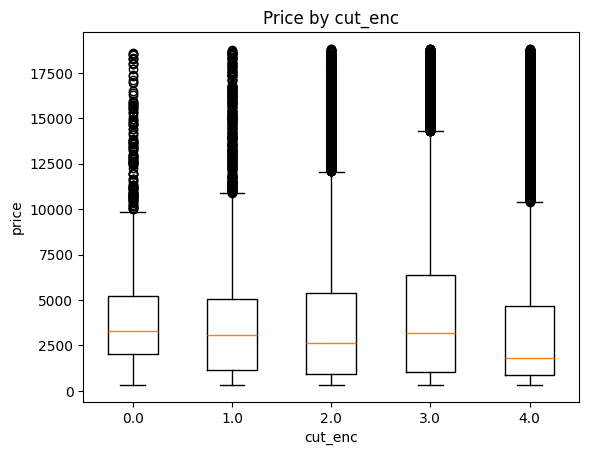

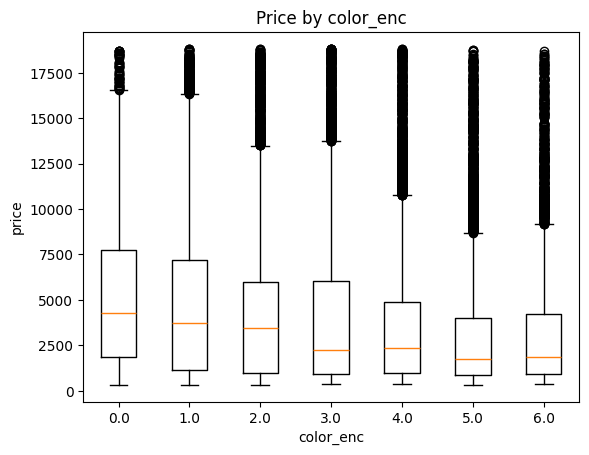

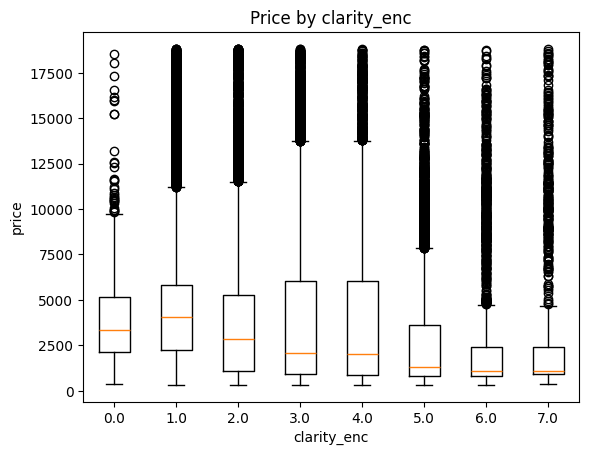

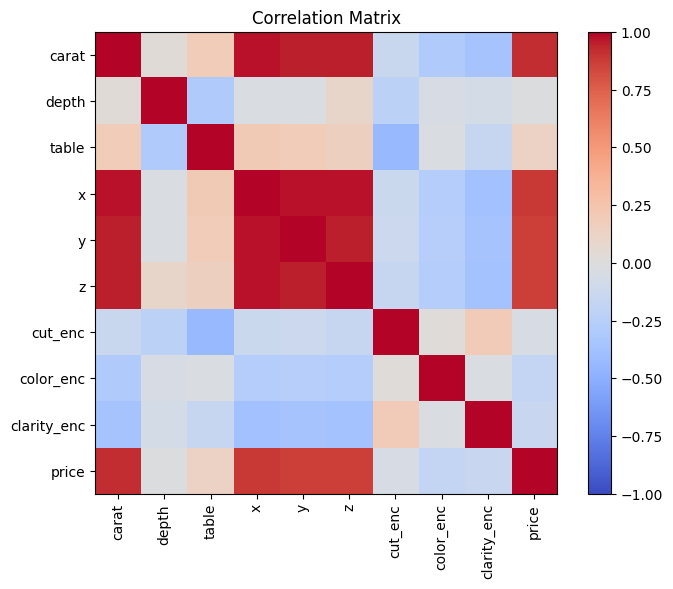

Top 5 features by |correlation| with price:
carat        0.921804
x            0.884919
y            0.864393
z            0.860963
color_enc    0.172629
Name: price, dtype: float64


In [ ]:
# Ordinally encode categorical features for linear analysis
enc = OrdinalEncoder(categories=[
    ['Fair','Good','Very Good','Premium','Ideal'],
    ['J','I','H','G','F','E','D'],
    ['I1','SI2','SI1','VS2','VS1','VVS2','VVS1','IF']
])
df[['cut_enc','color_enc','clarity_enc']] = enc.fit_transform(df[['cut','color','clarity']])

# Scatter plots with regression lines for numeric features vs. price
numeric_feats = ['carat','depth','table','x','y','z']
for feat in numeric_feats:
    plt.figure()
    plt.scatter(df[feat], df['price'], alpha=0.3)
    m, b = np.polyfit(df[feat], df['price'], 1)
    plt.plot(df[feat], m * df[feat] + b, color='red')
    plt.xlabel(feat)
    plt.ylabel('price')
    plt.title(f'Price vs {feat}')
    plt.show()

# Boxplot: price by ordinally encoded categories
for enc_feat in ['cut_enc','color_enc','clarity_enc']:
    plt.figure()
    data = [df[df[enc_feat] == level]['price'] for level in sorted(df[enc_feat].unique())]
    plt.boxplot(data, labels=sorted(df[enc_feat].unique()))
    plt.xlabel(enc_feat)
    plt.ylabel('price')
    plt.title(f'Price by {enc_feat}')
    plt.show()

# Correlation matrix heatmap
corr = df[numeric_feats + ['cut_enc','color_enc','clarity_enc','price']].corr()
plt.figure(figsize=(8, 6))
plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)
plt.title('Correlation Matrix')
plt.show()

# 5. Print top 5 features by absolute correlation with price
corr_with_price = corr['price'].abs().drop('price').sort_values(ascending=False)
print("Top 5 features by |correlation| with price:")
print(corr_with_price.head(5))

# Linear regression model

In [17]:
# Assign feature types
numeric_features = ['carat', 'depth', 'table', 'x', 'y', 'z']
categorical_features = ['cut', 'color', 'clarity']

X = df[numeric_features + categorical_features]
y = df['price']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(handle_unknown="ignore", drop='first'), categorical_features)
])

pipe = Pipeline([
    ("pre", preprocessor),
    ("lr", LinearRegression())
])

# Fit model
pipe.fit(X_train, y_train);

# Model evaluation

Buffer accuracy (±$500): 47.78%
Test MSE: 1186751.08
Test MAE: 718.92
Test R²: 0.923


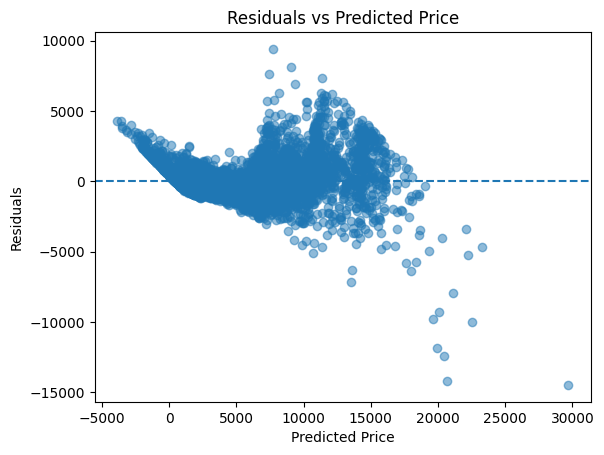

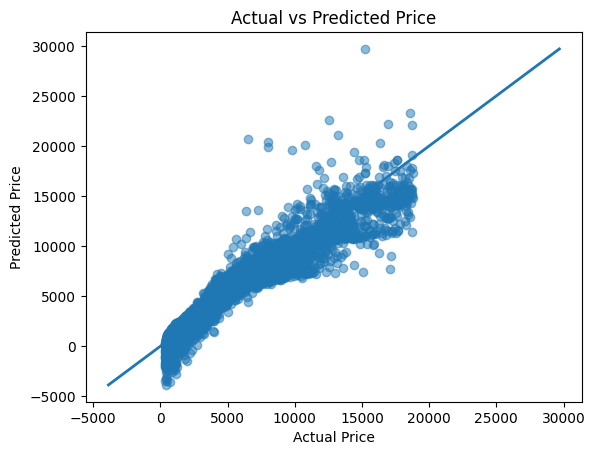

In [21]:
# model evaluation
y_pred = pipe.predict(X_test)
y_true = y_test

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2  = r2_score(y_true, y_pred)

buffer = 500
buffer_accuracy = np.mean(np.abs(y_true - y_pred) <= buffer) * 100

print(f"Buffer accuracy (±$500): {buffer_accuracy:.2f}%")
print(f"Test MSE: {mse:.2f}")
print(f"Test MAE: {mae:.2f}")
print(f"Test R²: {r2:.3f}")

# residuals vs predicted
residuals = y_true - y_pred
plt.figure()
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, linestyle='--')
plt.xlabel("Predicted Price")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Price")
plt.show()

# actual vs predicted
lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
plt.figure()
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot(lims, lims, linewidth=2)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Price")
plt.show()

# Discussion of results

R²=0.923 shows the linear model explains most variance but MAE=718.92 and buffer accuracy of 47.78% expose poor precision. Residuals widen at high prices, signaling inability to fit nonlinear scaling of price with carat and quality jumps in cut/color/clarity. The actual-vs-predicted plot curves away from the identity line at extreme values. Underfitting likely results from imposing a fixed slope per feature, so linear regression captures the rough trend but misses accelerating price effects and categorical interactions.